<a href="https://colab.research.google.com/github/yuhongtay/CS5228proj/blob/feature%2Fnearest-locations/CS5228_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import os
import requests
import time
import pickle
from scipy.spatial import KDTree
from pyproj import Transformer

Read Input Data: Load a CSV of HDB blocks and streets.

Coordinate Conversion: Convert latitude/longitude (WGS84) to SVY21 easting/northing using pyproj.

Auxiliary Data: Load nearby points of interest (hawker centres, MRT stations, schools, shopping malls) and build KD-Trees for fast nearest-neighbour queries.

Query OneMap API: Retrieve precise coordinates for each HDB block/street using an authenticated request.

Find Nearest Amenities: For each HDB, query the KD-Trees to find the nearest amenity and compute Manhattan distance.

Save Results: Store HDB coordinates, nearest amenity info, and distances in an output CSV.

Optional Caching: KD-Trees and auxiliary data can be saved/loaded as pickle files for faster repeated runs.

In [4]:
# === CONFIG ===
TOKEN = "eyJ1c2VyX2lkIjo4Njg1LCJmb3JldmVyIjpmYWxzZSwiaXNzIjoiT25lTWFwIiwiaWF0IjoxNzU3MTY5NDIwLCJuYmYiOjE3NTcxNjk0MjAsImV4cCI6MTc1NzQyODYyMCwianRpIjoiMzIzNjM1ODctMmMzOS00NmNkLThlZGItNjY3Y2ZjNTA2NzhiIn0"  # replace with your real token
INPUT_CSV = "train.csv"
OUTPUT_CSV = "output.csv"
AUX_DIR = "./"
TREE_DIR = "trees"
SLEEP_TIME = 0.1
start_idx = 0
end_idx = 10  # exclusive

CATEGORIES = {
    "hawker": "sg-gov-hawkers.csv",
    "mrt": "sg-mrt-stations.csv",
    "pri-school": "sg-primary-schools.csv",
    "sec-school": "sg-secondary-schools.csv",
    "shopping-mall": "sg-shopping-malls.csv"
}

ALL_COLUMNS = ["INDEX", "BLOCK", "STREET", "HDB_LAT", "HDB_LON", "HDB_X", "HDB_Y"]
for key in CATEGORIES.keys():
    ALL_COLUMNS += [
        f"nearest-{key}-name",
        f"nearest-{key}-lat",
        f"nearest-{key}-lon",
        f"nearest-{key}-x",
        f"nearest-{key}-y",
        f"nearest-{key}-manhattan"
    ]


os.makedirs(TREE_DIR, exist_ok=True)

# --- Transformer ---
transformer = Transformer.from_crs("epsg:4326", "epsg:3414", always_xy=True)
def latlon_to_svy21(lat, lon):
    return transformer.transform(lon, lat)  # lon first, then lat

# --- API call ---
def get_coords(block, street, max_retries=3, timeout=15):
    query = f"{block} {street}"
    url = "https://www.onemap.gov.sg/api/common/elastic/search"
    headers = {"Authorization": f"Bearer {TOKEN}"}
    params = {"searchVal": query, "returnGeom": "Y", "getAddrDetails": "Y", "pageNum": 1}

    for attempt in range(max_retries):
        try:
            resp = requests.get(url, headers=headers, params=params, timeout=timeout)
            if resp.status_code != 200:
                print(f"Attempt {attempt+1}: HTTP {resp.status_code} for {query}")
                continue
            results = resp.json().get("results", [])
            if results:
                r = results[0]
                lat = float(r.get("LATITUDE", None))
                lon = float(r.get("LONGITUDE", None))
                addr = r.get("ADDRESS", "")
                return lat, lon, addr
            return None, None, None
        except Exception as e:
            print(f"Attempt {attempt+1} error fetching {query}: {e}")
            time.sleep(1)  # brief pause before retry
    return None, None, None


# --- Load/build KDTree ---
trees = {}
aux_dfs = {}
for key, fname in CATEGORIES.items():
    csv_path = os.path.join(AUX_DIR, fname)
    tree_path = os.path.join(TREE_DIR, f"{key}_tree.pkl")
    aux_df_path = os.path.join(TREE_DIR, f"{key}_df.pkl")

    if os.path.exists(tree_path) and os.path.exists(aux_df_path):
        with open(tree_path, "rb") as f:
            trees[key] = pickle.load(f)
        with open(aux_df_path, "rb") as f:
            aux_dfs[key] = pickle.load(f)
    else:
        df = pd.read_csv(csv_path)
        df["X"], df["Y"] = zip(*df.apply(lambda r: latlon_to_svy21(r["LATITUDE"], r["LONGITUDE"]), axis=1))
        aux_dfs[key] = df
        trees[key] = KDTree(df[["X", "Y"]].values)
        with open(tree_path, "wb") as f:
            pickle.dump(trees[key], f)
        with open(aux_df_path, "wb") as f:
            pickle.dump(df, f)

# --- Load input CSV ---
df = pd.read_csv(INPUT_CSV)

# --- Process each row and add columns directly ---
for idx, row in df.iloc[start_idx:end_idx].iterrows():
    block, street = row["BLOCK"], row["STREET"]

    lat, lon, addr = get_coords(block, street)
    if lat is None or lon is None:
        continue
    x, y = latlon_to_svy21(lat, lon)

    df.loc[idx, "HDB_LAT"] = lat
    df.loc[idx, "HDB_LON"] = lon
    df.loc[idx, "HDB_X"] = x
    df.loc[idx, "HDB_Y"] = y

    for key in CATEGORIES.keys():
        tree = trees[key]
        aux_df = aux_dfs[key]
        _, nn_idx = tree.query([x, y])
        nearest = aux_df.iloc[nn_idx]
        nx, ny = nearest["X"], nearest["Y"]
        manhattan = abs(x - nx) + abs(y - ny)

        df.loc[idx, f"nearest-{key}-name"] = nearest["NAME"]
        df.loc[idx, f"nearest-{key}-lat"] = nearest["LATITUDE"]
        df.loc[idx, f"nearest-{key}-lon"] = nearest["LONGITUDE"]
        df.loc[idx, f"nearest-{key}-x"] = nx
        df.loc[idx, f"nearest-{key}-y"] = ny
        df.loc[idx, f"nearest-{key}-manhattan"] = manhattan

    time.sleep(SLEEP_TIME)

# --- Save updated CSV ---
df.to_csv(INPUT_CSV, index=False)
print(f"Updated {INPUT_CSV} with new columns.")

Updated train.csv with new columns.


/tmp/ipython-input-3272638854.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/tmp/ipython-input-3272638854.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


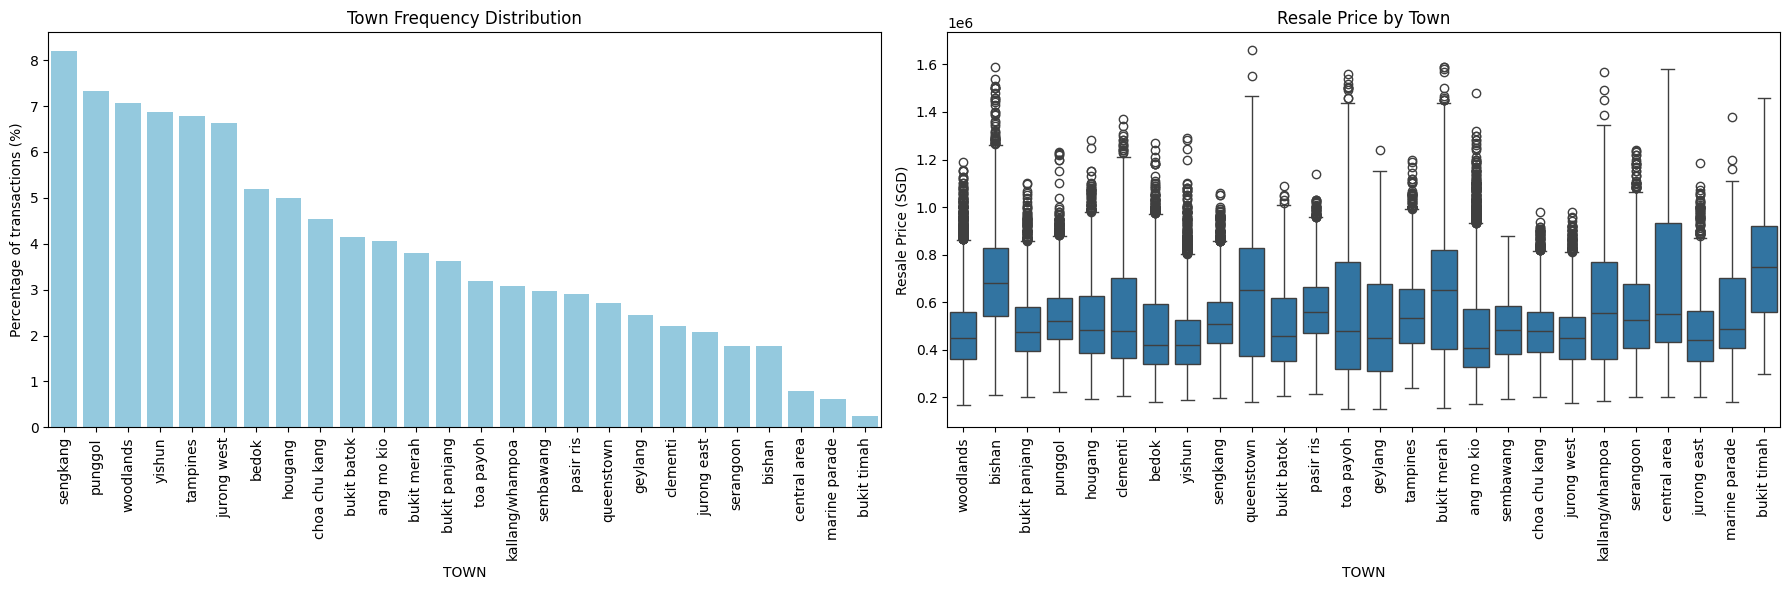

/tmp/ipython-input-3272638854.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/tmp/ipython-input-3272638854.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


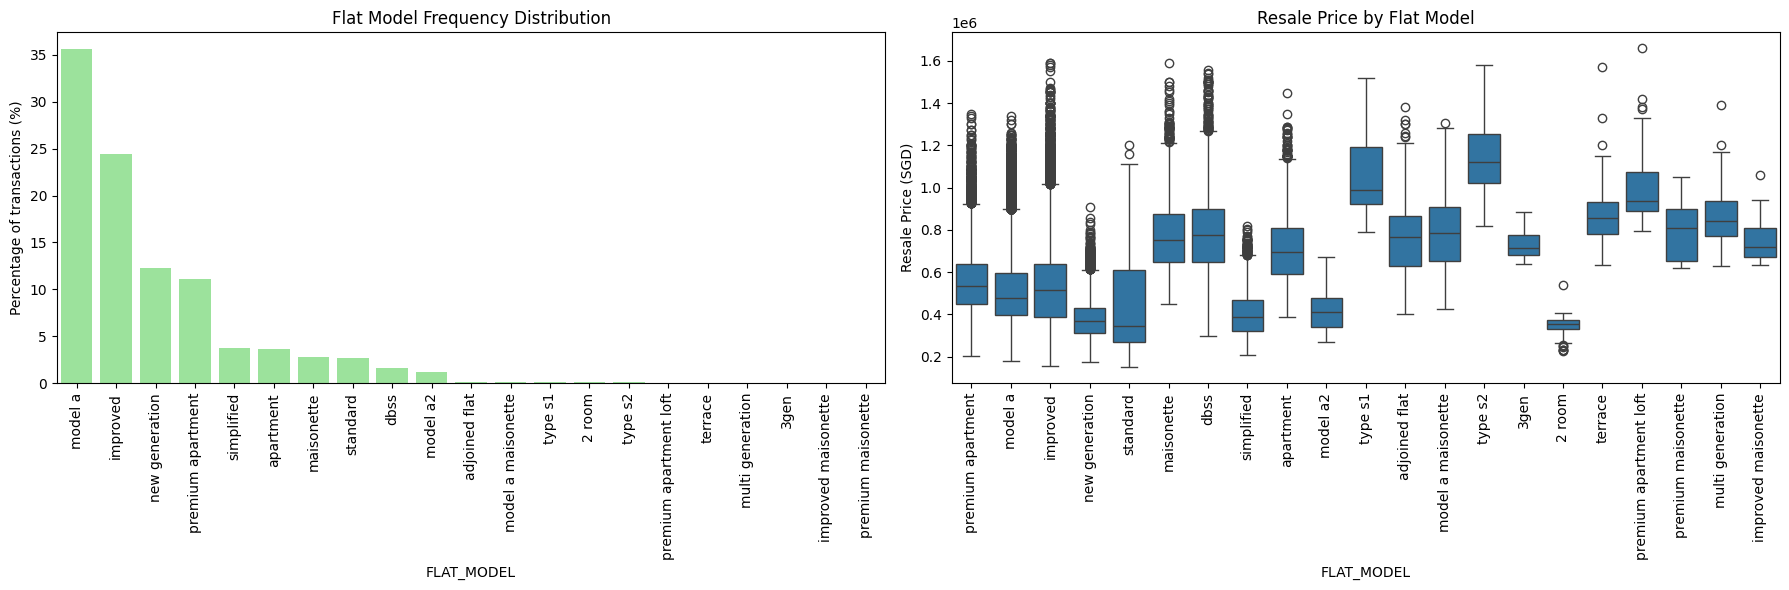

/tmp/ipython-input-3272638854.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/tmp/ipython-input-3272638854.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


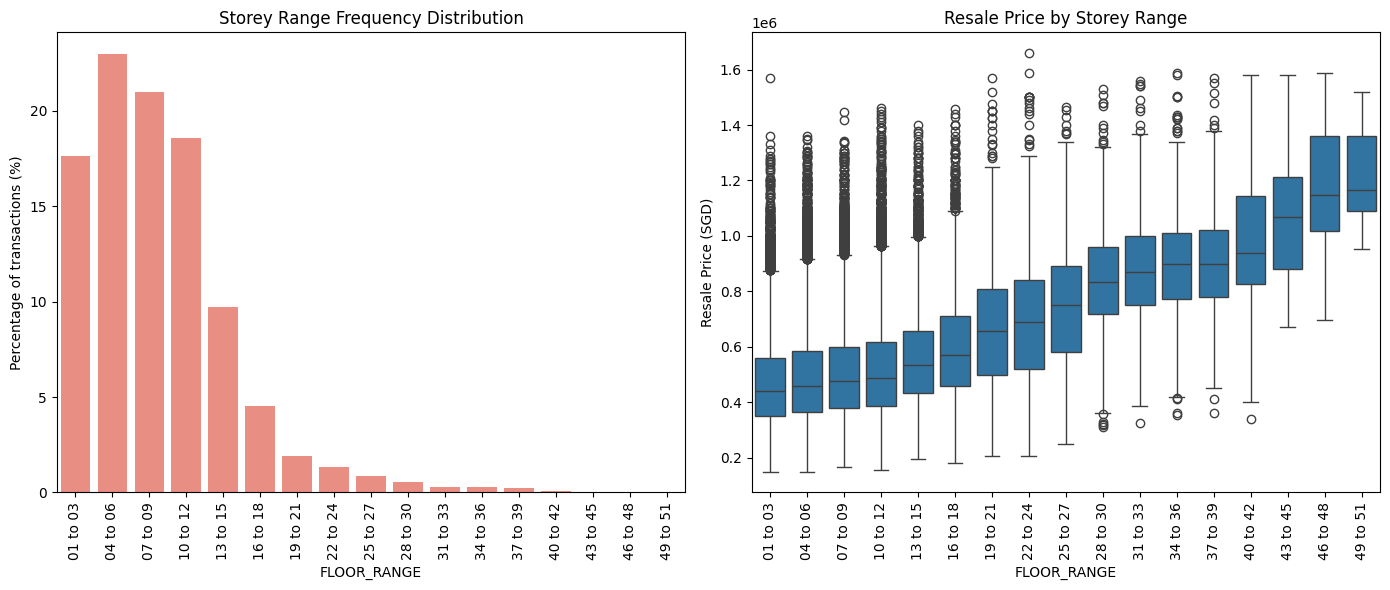

In [ ]:
#quick EDA of non-numerical data
# ------------------------------
# 1. Town
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18,6))

# Frequency (percentage)
town_counts = train_df['TOWN'].value_counts(normalize=True).sort_values(ascending=False) * 100
sns.barplot(x=town_counts.index, y=town_counts.values, color="skyblue", ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_ylabel("Percentage of transactions (%)")
axes[0].set_title("Town Frequency Distribution")

# Resale price distribution by town
sns.boxplot(x="TOWN", y="RESALE_PRICE", data=train_df, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_ylabel("Resale Price (SGD)")
axes[1].set_title("Resale Price by Town")

plt.tight_layout()
plt.show()

# ------------------------------
# 2. Flat Model
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18,6))

model_counts = train_df['FLAT_MODEL'].value_counts(normalize=True).sort_values(ascending=False) * 100
sns.barplot(x=model_counts.index, y=model_counts.values, color="lightgreen", ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_ylabel("Percentage of transactions (%)")
axes[0].set_title("Flat Model Frequency Distribution")

sns.boxplot(x="FLAT_MODEL", y="RESALE_PRICE", data=train_df, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_ylabel("Resale Price (SGD)")
axes[1].set_title("Resale Price by Flat Model")

plt.tight_layout()
plt.show()

# ------------------------------
# 3. Storey Range
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

storey_counts = train_df['FLOOR_RANGE'].value_counts(normalize=True).sort_index() * 100
sns.barplot(x=storey_counts.index, y=storey_counts.values, color="salmon", ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_ylabel("Percentage of transactions (%)")
axes[0].set_title("Storey Range Frequency Distribution")

sns.boxplot(x="FLOOR_RANGE", y="RESALE_PRICE", data=train_df, order=sorted(train_df['FLOOR_RANGE'].unique()), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_ylabel("Resale Price (SGD)")
axes[1].set_title("Resale Price by Storey Range")

plt.tight_layout()
plt.show()

In [ ]:
# Load train data
train_df = pd.read_csv('train.csv')

In [ ]:
# preprocess data
def preprocess(df, is_train=True, scaler=None):
    df = df.copy()

    # Drop ECO_CATEGORY if entirely unknown
    if 'ECO_CATEGORY' in df.columns:
        if df['ECO_CATEGORY'].nunique() == 1 and df['ECO_CATEGORY'].iloc[0] in ['UNKNOWN','uncategorized','']:
            df.drop(columns=['ECO_CATEGORY'], inplace=True)

    # Clean strings
    for col in ['TOWN','STREET','FLAT_TYPE','FLAT_MODEL']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.lower()

    # Rename lease column if needed
    if 'LEASE_COMMENCE_DATA' in df.columns:
        df.rename(columns={'LEASE_COMMENCE_DATA': 'LEASE_COMMENCE_DATE'}, inplace=True)

    # FLOOR_RANGE → numeric midpoint
    floor_nums = df['FLOOR_RANGE'].str.extract(r'(\d+)\s*to\s*(\d+)').astype(float)
    df['mid_floor'] = floor_nums.mean(axis=1)

    # MONTH → extract year, month, quarter.
    df['sale_year'] = pd.to_datetime(df['MONTH']).dt.year.astype(int)
    df['sale_month'] = pd.to_datetime(df['MONTH']).dt.month.astype(int)
    df['sale_quarter'] = pd.to_datetime(df['MONTH']).dt.quarter.astype(int)

    # Lease calculations
    df['lease_age'] = df['sale_year'] - df['LEASE_COMMENCE_DATE']
    df['remaining_lease'] = 99 - df['lease_age']

    # Ordinal encode FLAT_TYPE
    if 'FLAT_TYPE' in df.columns:
        # remove spaces and dashes
        df['FLAT_TYPE'] = df['FLAT_TYPE'].str.replace(' ','').str.replace('-','')
        # assign ordinal values
        flat_type_mapping = {
            '1room': 1,
            '2room': 2,
            '3room': 3,
            '4room': 4,
            '5room': 5,
            'executive': 6,
            'multigeneration': 7  # 3Gen / Multi-Generation
        }
        df['FLAT_TYPE_ORDINAL'] = df['FLAT_TYPE'].map(flat_type_mapping)

    # Numeric columns
    numeric_cols = ['FLOOR_AREA_SQM','mid_floor','lease_age','remaining_lease','RESALE_PRICE', 'FLAT_TYPE_ORDINAL']

    # Categorical columns
    categorical_cols = ['TOWN','FLAT_MODEL']

    # Drop STREET due to high cardinality
    top_streets = df['STREET'].value_counts().nlargest(50).index
    df['STREET'] = df['STREET'].where(df['STREET'].isin(top_streets), other='other')

    # One-hot encode, Drops the first category in each categorical column to avoid multicollinearity
    df_encoded = pd.get_dummies(df[numeric_cols + categorical_cols], drop_first=True)

    # Include target if exists
    if 'RESALE_PRICE' in df.columns:
        df_encoded['RESALE_PRICE'] = df['RESALE_PRICE']

    # Scale numeric features + target
    # Training set: We compute the mean and standard deviation (fit) and then scale.
    # Test set: We don’t recompute mean/std; we use the same mean and std from the training set to scale
    if is_train:
        scaler = StandardScaler()
        df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])
        return df_encoded, scaler
    else:
        df_encoded[numeric_cols] = scaler.transform(df_encoded[numeric_cols])
        return df_encoded
train_encoded, scaler = preprocess(train_df, is_train=True)
print(train_encoded)

        FLOOR_AREA_SQM  mid_floor  lease_age  remaining_lease  RESALE_PRICE  \
0             0.212595  -0.129297  -0.331871         0.331871     -0.539407   
1             0.295822  -0.129297   0.304716        -0.304716      0.361033   
2             0.212595   1.893489  -0.119675         0.119675     -0.375691   
3            -0.161930   1.387792  -1.463580         1.463580     -0.293833   
4             0.670347   0.376399  -1.392848         1.392848      1.043185   
...                ...        ...        ...              ...           ...   
162686       -0.245157  -1.140690   0.516911        -0.516911     -1.003271   
162687        0.295822  -0.634993   0.021789        -0.021789     -0.714038   
162688       -0.536454   0.376399   0.516911        -0.516911     -0.795896   
162689        0.545505  -1.140690  -0.402603         0.402603     -0.539407   
162690       -0.536454  -1.140690   0.658375        -0.658375     -0.894126   

        FLAT_TYPE_ORDINAL  TOWN_bedok  TOWN_bishan 

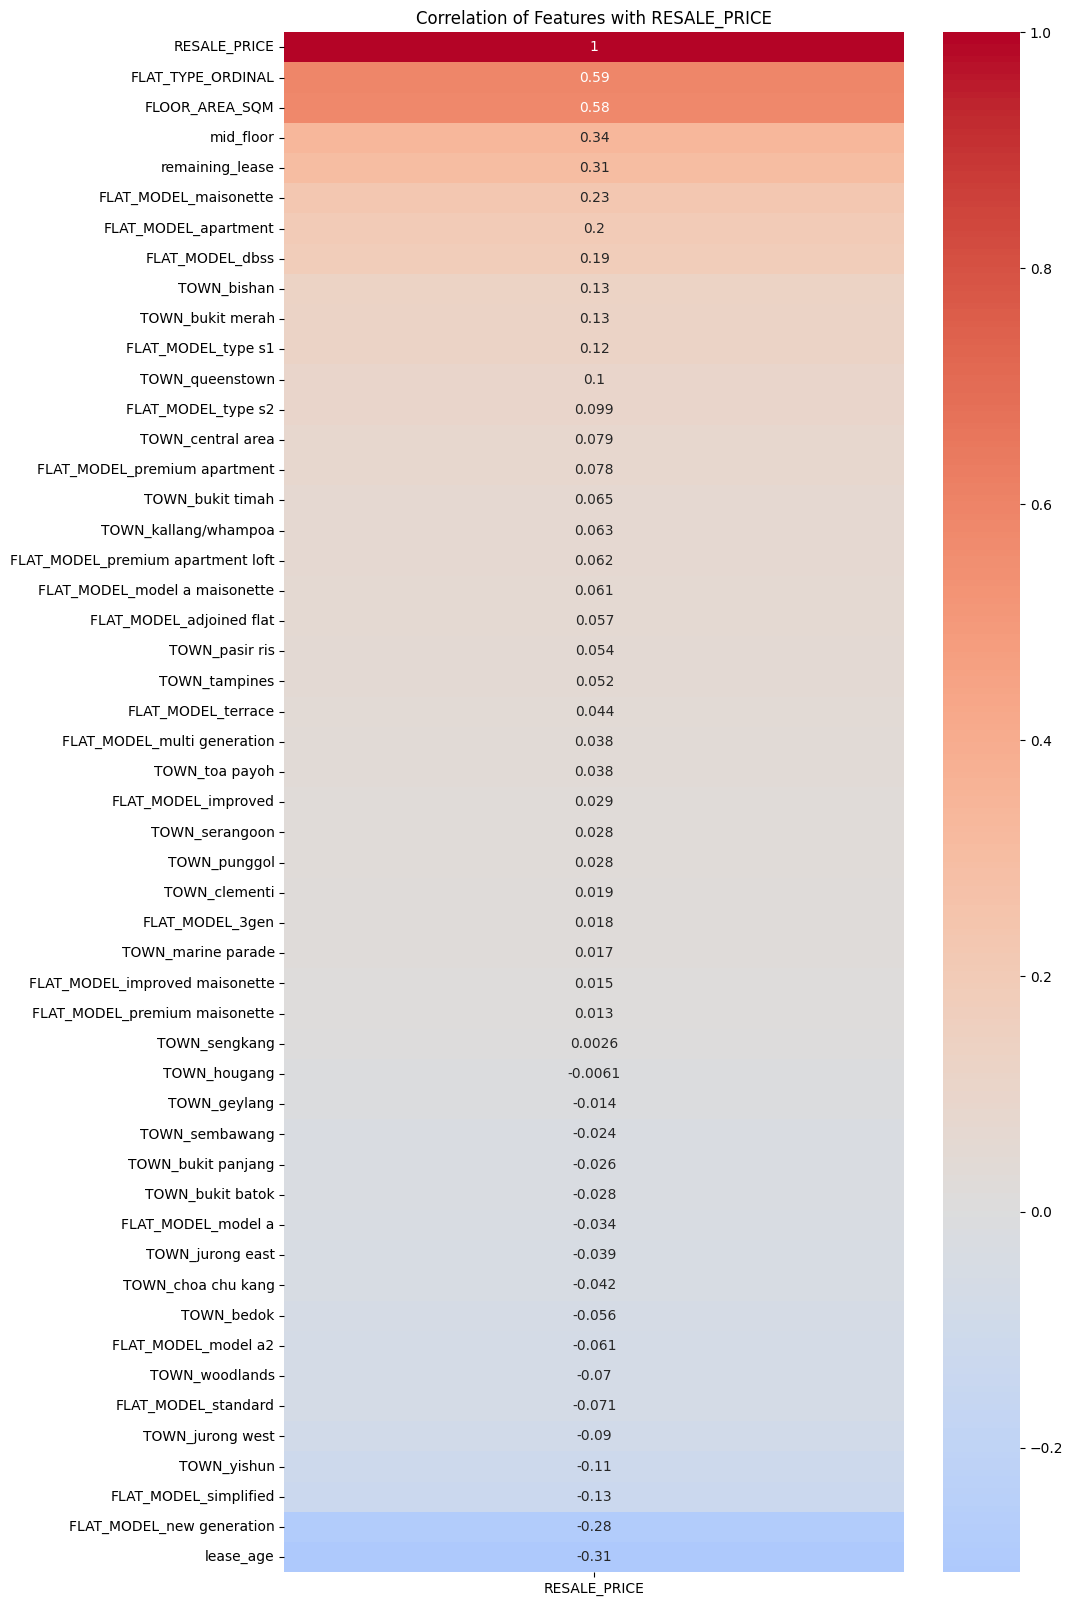

In [ ]:
# Compute correlation matrix
corr_matrix = train_encoded.corr()

# Select only correlations with RESALE_PRICE
corr_with_price = corr_matrix[['RESALE_PRICE']].sort_values(by='RESALE_PRICE', ascending=False)

# Plot heatmap
plt.figure(figsize=(10, 20))  # tall figure to fit all features
sns.heatmap(corr_with_price, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Features with RESALE_PRICE')
plt.show()

In [ ]:
# Split for validation
target = 'RESALE_PRICE'
X = train_encoded.drop(columns=[target])
y = train_encoded[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Linear Regression
model_lr = Ridge()
model_lr.fit(X_train, y_train)
preds_lr = model_lr.predict(X_val)
rmse_lr = np.sqrt(mean_squared_error(y_val, preds_lr))
print("Linear Regression RMSE:", rmse_lr)

Linear Regression RMSE: 0.48699370546926624


In [ ]:
# Decision Tree
model_dt = DecisionTreeRegressor(
    random_state=42,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=1
)
model_dt.fit(X_train, y_train)
preds_dt = model_dt.predict(X_val)
rmse_dt = np.sqrt(mean_squared_error(y_val, preds_dt))
print("Decision Tree RMSE:", rmse_dt)

Decision Tree RMSE: 0.43158483003615805


In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
preds_rf = model_rf.predict(X_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, preds_rf))
print("Random Forest RMSE:", rmse_rf)

Random Forest RMSE: 0.30070064817098446


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert all columns to float
X_train_numeric = X_train.astype(np.float32)
X_val_numeric = X_val.astype(np.float32)

# Convert to PyTorch tensors and move to GPU
X_train_t = torch.tensor(X_train_numeric.values, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val_numeric.values, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)
# Define neural network
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = Net(X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluate on validation set
model.eval()
with torch.no_grad():
    preds = model(X_val_t)
    rmse = torch.sqrt(criterion(preds, y_val_t))
    print("Neural Network RMSE (GPU):", rmse.item())



Using device: cuda
Epoch 50, Loss: 0.3652
Epoch 100, Loss: 0.2057
Epoch 150, Loss: 0.1858
Epoch 200, Loss: 0.1764
Epoch 250, Loss: 0.1691
Epoch 300, Loss: 0.1618
Epoch 350, Loss: 0.1538
Epoch 400, Loss: 0.1459
Epoch 450, Loss: 0.1390
Epoch 500, Loss: 0.1331
Neural Network RMSE (GPU): 0.36740756034851074
